In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
df_gemma = pd.read_csv('../data/judge/outputs/gemma_x3_stats.csv', header=[0, 1, 2])
df_qwen = pd.read_csv('../data/judge/outputs/qwen_x3_stats.csv')

KeyError: 'language_variant'

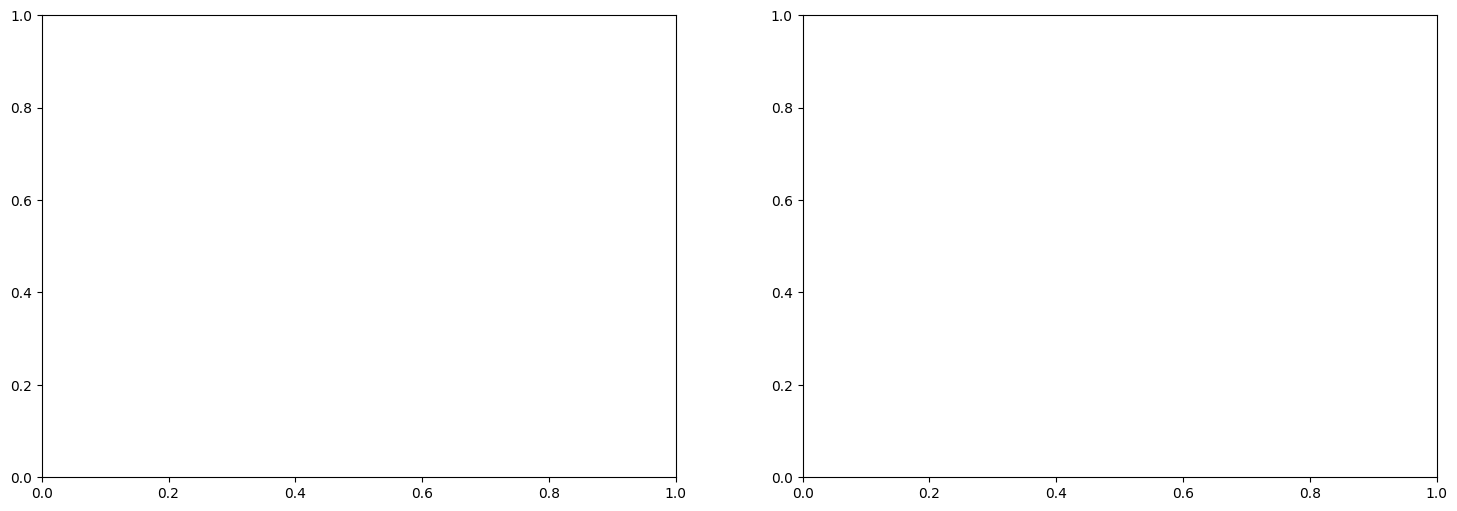

In [7]:
# Create a side-by-side comparison of sycophancy scores
# Left plot: Overall sycophancy score by category for each language variant
# Right plot: Average of regressive, validation, and framing components by category for each language variant
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Iterate over each unique language variant
for language_variant in df_gemma['language_variant'].unique():
    # Filter data for the current language variant
    subset = df_gemma[df_gemma['language_variant'] == language_variant]
    
    # Calculate mean overall sycophancy score per category
    means_overall = subset.groupby('category')['overall'].mean()
    # Plot on the left subplot
    axs[0].plot(means_overall.index, means_overall.values, marker='o', label=language_variant)
    
    # Calculate mean of the three components (regressive, validation, framing) per category
    means_components = subset.groupby('category')[['regressive', 'validation', 'framing']].mean().mean(axis=1)
    # Plot on the right subplot
    axs[1].plot(means_components.index, means_components.values, marker='o', label=language_variant)

# Configure left subplot
axs[0].set_title(f'Overall Sycophancy by Language Variant for gemma')
axs[0].set_xlabel('Category')
axs[0].set_ylabel('Average Overall Sycophancy Score')
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend()

# Configure right subplot
axs[1].set_title(f'Average Sycophancy Components by Language Variant for gemma')
axs[1].set_xlabel('Category')
axs[1].set_ylabel('Average Sycophancy Score')
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()